# Reconstruction demo

An introductory example showing a reconstruction pipeline using `simplecryoem`.

In [57]:
import numpy as np
from matplotlib import pyplot as plt
import jax.numpy as jnp
from jax import random
import warnings

from simplecryoem.emfiles import load_data
from simplecryoem.preprocess import preprocess
from simplecryoem.forwardmodel import Slice
from simplecryoem.optimization import Loss, GradV, sgd, get_sgd_vol_ops
from simplecryoem.utils import mip_z

In [2]:
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('error', category=DeprecationWarning)
plt.rcParams["figure.figsize"] = 6, 6

### Load the data

First, use the `load_data` function to load the particle images from the _mrcs_ file and their parameters from the _star_ file.

In [11]:
data_dir = "../data_demo/clean/"
star_file = "particles.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs=True, fourier=False)

print(f"params0 keys: {params0.keys()}")
print(f"imgs0.shape = {imgs0.shape}")

load_data: number of partcles: 1000
load_data: data loaded, time:  0.10 sec.
params0 keys: dict_keys(['ctf_params', 'pixel_size', 'angles', 'shifts'])
imgs0.shape = (1000, 64, 64)


### Preprocess the data

Some basic preprocessing: compute the Fourier transform of the images and extract the angles, shifts and the CTF parameters from the `params0` dictionary.

In [12]:
processed_data = preprocess(imgs0, params0)

imgs0.shape = (1000, 64, 64)
pixel_size0.shape = (1000,)
angles0.shape = (1000, 3)
shifts0.shape = (1000, 2)
ctf_params0.shape = (1000, 9)
N0 = 1000
idx not provided
N = 1000
Taking FFT of the images:
Batch 1/10  0.01 sec.
Batch 2/10  0.01 sec.
Batch 3/10  0.01 sec.
Batch 4/10  0.01 sec.
Batch 5/10  0.01 sec.
Batch 6/10  0.01 sec.
Batch 7/10  0.01 sec.
Batch 8/10  0.01 sec.
Batch 9/10  0.00 sec.
Batch 10/10  0.00 sec.
FFT done. Time:  0.07 sec.
x_grid = [1.25549303e-02 6.40000000e+01]
Vectorised imgs_f.shape = (1000, 4096)
Mask radius = 0.389202840266735
Noise free, setting sigma_noise = 1


In [13]:
# Images and image-specific parameters
imgs_f = processed_data["imgs_f"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]

# These parameters are the same for all images
pixel_size = processed_data["pixel_size"]
nx = processed_data["nx"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
x_grid = processed_data["x_grid"]
N = imgs_f.shape[0]

And display a projection image.

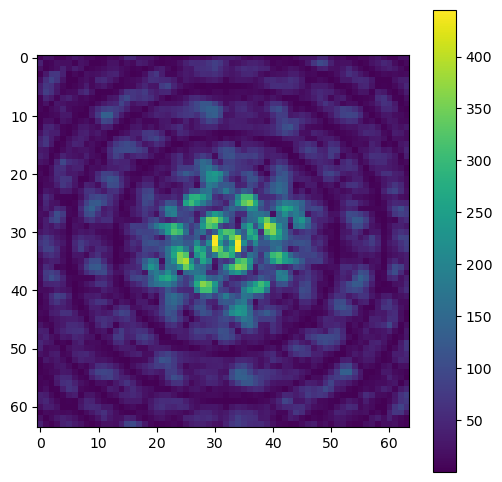

In [16]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[15].reshape([nx, nx]))))
plt.colorbar()

One last preprocessing step we will do is to apply a spherical mask to avoid issues related to rotating voxels in the corner of the 3D grid.

In [19]:
# Use the x=0 slice of the 3D mask output by the preprocess function
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

Dispay the mask and a masked image

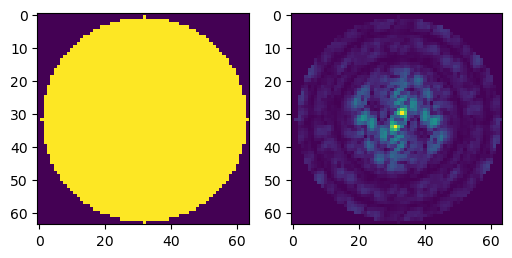

In [25]:
plt.subplot(1, 2, 1)
plt.imshow(jnp.fft.fftshift(mask[0]))

plt.subplot(1, 2, 2)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[123].reshape([nx, nx]))))

### Reconstruction

First, we need to set a few parameters:
* The egularization parameter $\alpha$ that will be used in the loss function
* The interpolation method: since the forward model involves rotating the input volume (or the coordinates), the rotated volume and the coordinate grid will end up misaligned. We compute the value of the rotated volume at the off-the-grid points using trilinear or nearest-neighbour interpolation.

In [67]:
# Regularization parameter
alpha = 1e-3

# Interpolation method
interp_method = "tri"

Finally, we instantiate the main components of `simplecryoem`:
* Slice
* Loss
* GradV

In [68]:
slice_obj = Slice(x_grid, mask=mask, interp_method=interp_method)
loss_obj = Loss(slice_obj, alpha=alpha)
gradv_obj = GradV(loss_obj)

Using these object, we can create functions that that evaluate the loss and the gradient of the loss using minibatches of particle images.

In [69]:
grad_func, loss_func, _, _ = get_sgd_vol_ops(
    gradv_obj, loss_obj, angles, shifts, ctf_params, imgs_f, sigma_noise
)

### Run SGD

In [70]:
# Pseudo-random number generator key
key = random.PRNGKey(10)

# Initialization
v0 = jnp.zeros((nx,nx,nx))
    
N_epochs = 10
batch_size = 100
step_size = 10
c = 0.9

In [71]:
key, key_alg = random.split(key)

v_rec, loss_rec, grad_rec, iterates, step_sizes = sgd(
    key_alg,
    grad_func,
    loss_func,
    N,
    v0,
    step_size,
    N_epochs,
    batch_size,
    c=c,
    adaptive_step_size=True,
    verbose=True,
    iter_display=1,
)

Epoch 1/10 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.98it/s, eta=2.500e+00, grad=1.944e+01, loss=1.049e+07]


  |Grad| = 3.987e+01
  Loss = 1.03511087e+07
  eta = 2.5
  alpha = 1e-10
Epoch 2/10 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.41it/s, eta=2.500e+00, grad=1.721e+01, loss=1.021e+07]


  |Grad| = 1.358e+01
  Loss = 1.02104180e+07
  eta = 2.5
  alpha = 1e-10
Epoch 3/10 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.49it/s, eta=5.000e+00, grad=1.214e+01, loss=1.016e+07]


  |Grad| = 1.393e+01
  Loss = 1.01872492e+07
  eta = 5.0
  alpha = 1e-10
Epoch 4/10 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.47it/s, eta=5.000e+00, grad=1.518e+01, loss=1.022e+07]


  |Grad| = 1.552e+01
  Loss = 1.01723063e+07
  eta = 5.0
  alpha = 1e-10
Epoch 5/10 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.44it/s, eta=5.000e+00, grad=1.859e+01, loss=1.044e+07]


  |Grad| = 1.770e+01
  Loss = 1.01666485e+07
  eta = 5.0
  alpha = 1e-10
Epoch 6/10 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.46it/s, eta=5.000e+00, grad=1.364e+01, loss=1.009e+07]


  |Grad| = 1.425e+01
  Loss = 1.01618708e+07
  eta = 5.0
  alpha = 1e-10
Epoch 7/10 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.39it/s, eta=5.000e+00, grad=1.503e+01, loss=1.011e+07]


  |Grad| = 1.561e+01
  Loss = 1.01575338e+07
  eta = 5.0
  alpha = 1e-10
Epoch 8/10 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.45it/s, eta=5.000e+00, grad=1.903e+01, loss=1.033e+07]


  |Grad| = 1.547e+01
  Loss = 1.01583395e+07
  eta = 5.0
  alpha = 1e-10
Epoch 9/10 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.45it/s, eta=5.000e+00, grad=1.419e+01, loss=1.035e+07]


  |Grad| = 1.489e+01
  Loss = 1.01561329e+07
  eta = 5.0
  alpha = 1e-10
Epoch 10/10 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.38it/s, eta=2.500e+00, grad=1.476e+01, loss=1.025e+07]


  |Grad| = 1.484e+01
  Loss = 1.01519727e+07
  eta = 2.5
  alpha = 1e-10


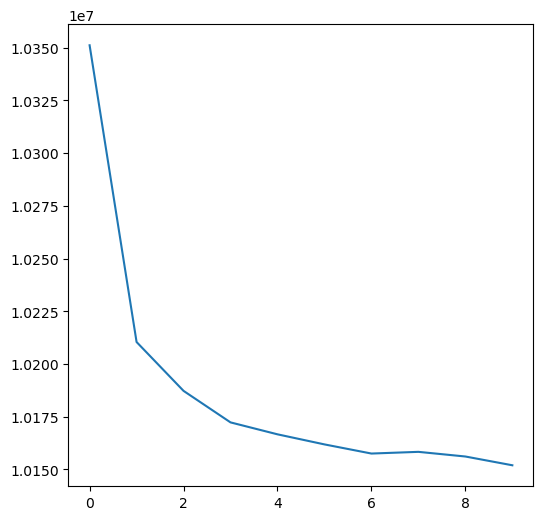

In [72]:
plt.plot(loss_rec)

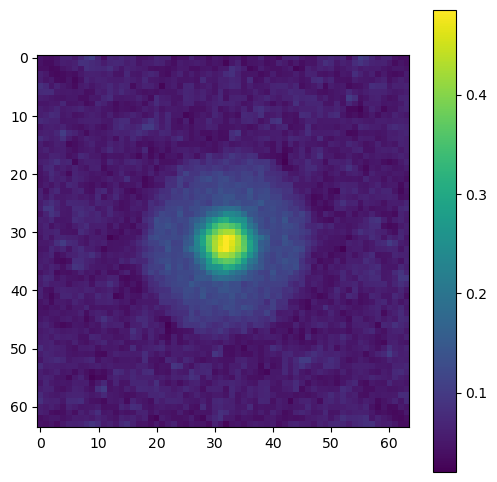

In [75]:
#mip_z(v_rec) 

vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))

mip_z(vr_sgd)
plt.colorbar()